In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
# pip install tensorflow-addons==0.16.1
# pip install numpy

# **Importing necessary libraries**

In [5]:

import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from random import randrange
# import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# **User-defined inputs**

In [13]:
## Please give KFOLDS = a perfect divisor for 400
PATH ='Assignment4Dataset.csv'
KFOLDS = 4
EPOCHS = 20
BATCH_SIZE = 64 
INIT_LR = 0.0001
MAX_LR = 0.001
DEFAULT_REGULARIZER = 0.9
DEFAULT_LEARNING_RATE = 0.001

# **Define cyclic learning rate here. You can also define your own function. We have used pre-defined library from tensor flow.**

# **Reading the data and print its distribution**

In [286]:
df = pd.read_csv(PATH)
df.columns = ['f1', 'f2', 'class']
print("FIRST 5 DATA POINTS: \n", df.head())
print("DISTRIBUTION OF DATA CLASS WISE:\n" ,df.groupby(['class'])['class'].count())

FIRST 5 DATA POINTS: 
       f1      f2  class
0 -1.520 -1.1500      1
1 -1.050  0.7200     -1
2 -0.916  0.3970      1
3 -1.090  0.4370      1
4 -0.584  0.0937      1
DISTRIBUTION OF DATA CLASS WISE:
 class
-1    2923
 1    2376
Name: class, dtype: int64


# **Creating new features from f1 to fn. User can define their own transformations here.**

In [287]:
data = df[['f1', 'f2']]
label = df['class']

## Create new features from f1 and f2
data['f3'] = data['f1']**2 + data['f2']**2
data['f4'] = data['f1']**2
data['f5'] = data['f2']**2
data['f6'] = data['f1'] * data['f2']
data['f7'] = data['f1'] * data['f1']
data['f8'] = data['f2'] * data['f2']
data['f9'] = (data['f1'] * data['f2'] + 1)**2
data['f10'] = np.exp(-0.3*(data['f1'] - data['f2'])**2)

print(data.head())

      f1      f2        f3        f4        f5        f6        f7        f8  \
0 -1.520 -1.1500  3.632900  2.310400  1.322500  1.748000  2.310400  1.322500   
1 -1.050  0.7200  1.620900  1.102500  0.518400 -0.756000  1.102500  0.518400   
2 -0.916  0.3970  0.996665  0.839056  0.157609 -0.363652  0.839056  0.157609   
3 -1.090  0.4370  1.379069  1.188100  0.190969 -0.476330  1.188100  0.190969   
4 -0.584  0.0937  0.349836  0.341056  0.008780 -0.054721  0.341056  0.008780   

         f9       f10  
0  7.551504  0.959762  
1  0.059536  0.390679  
2  0.404939  0.596193  
3  0.274230  0.496824  
4  0.893553  0.871288  


# **We plot the graph of the given data and see if it's linearly seperable or not**

# **Plot with different features**

**Plot for f1 and f2**

In [288]:
x = data.to_numpy()
y = label.to_numpy()
plt.scatter(x[:,0][y==-1], x[:,1][y==-1], s=3, c='r')
plt.scatter(x[:,0][y==1], x[:,1][y==1], s=3, c='b')
plt.savefig('original_grid.jpg')
# plt.show()
plt.close()

**Plot for f1 and f3**

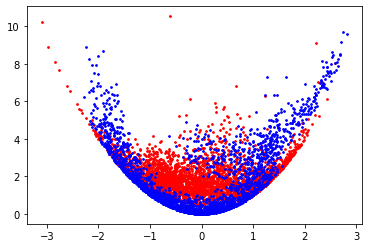

In [289]:
x = data.to_numpy()
y = label.to_numpy()
plt.scatter(x[:,0][y==-1], x[:,2][y==-1], s=3, c='r')
plt.scatter(x[:,0][y==1], x[:,2][y==1], s=3, c='b')
plt.show()

**Plot for f2 and f4**

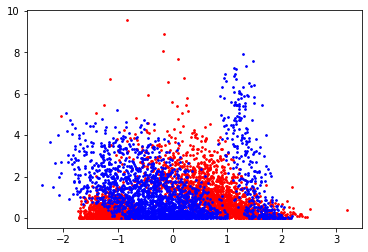

In [290]:
x = data.to_numpy()
y = label.to_numpy()
plt.scatter(x[:,1][y==-1], x[:,3][y==-1], s=3, c='r')
plt.scatter(x[:,1][y==1], x[:,3][y==1], s=3, c='b')
plt.show()

# **Loss Function**

In [291]:
def get_loss(X, y, w, regularizer):
    numOfDataPoints = X.shape[0]
    numOfFeatures = X[0].shape
    ## Handle the dimesnions for multiplicity
    Xw = np.dot(X, w)
    # print(np.dot((y - Xw).T, (y - Xw)).shape)
    loss = np.dot((y - Xw).T, (y - Xw)).item() / (2 * numOfDataPoints) 
    gradient = (np.dot(X.T, (y - Xw))) / numOfDataPoints - regularizer*w

    return loss, gradient

# **Mini-batch Gradient Descent**

In [292]:
## Function for dividing the data into batches
def get_batches(X, y, batch_size, i):
    X_new = np.array(X[i:i+batch_size,:])
    y_new = np.resize(y[i:i+batch_size], (batch_size,1))  
    return X_new, y_new
    

## Mini-Batch Gradient Descent
def MiniBatchGradientDescent(X, y, w, batch_size, lr_init=0.0001, regularizer=0.9, num_iter=500, schedule=None):
    """
    X           : Input data
    y           : Input labels
    w           : Model parameters
    batch_size  : Batch size for minibatch gradient descent
    lr-init     : Initial learning rate
    regularizer : Regularization coefficient
    num_iter    : Total number of epochs 
    schedule    : A function pointer for user defined input which takes epoch as input. User can define own scheduler function with epoch as a input and pass the function pointer to this argument.
    """
    num_batches = int(X.shape[0]/batch_size)
    gradient = 0
    loss_list = []
    # init_loss, init_grad = get_loss(X[0].reshape(1, X.shape[1]), y[0].reshape(1,1), w, regularizer)
    # loss_list.append(init_loss)
    learning_rate = lr_init
    for epoch in range(num_iter):
        loss_per_epoch = 0
        for iter in range(num_batches):
            i = randrange(len(y)-batch_size)
            X_batch, y_batch = get_batches(X,y,batch_size,i)
            loss, gradient = get_loss(X_batch, y_batch, w, regularizer)
            if epoch == 0 and iter == 0:
                loss_list.append(loss)
            loss_per_epoch += loss
            if schedule:
                learning_rate = schedule(iter)
            else:
                learning_rate = lr_init / (1+regularizer*iter)
            w = w + learning_rate * gradient
        loss_list.append(loss_per_epoch)

    return w, loss_list

# **Stochastic Gradient Descent**

In [293]:
## Stochastic Gradient Descent
def StochasticGradientDescent(X, y, w, lr_init=0.001, regularizer=0.9, num_iter=500, schedule=None):
    """
    X           : Input data
    y           : Input labels
    w           : Model parameters
    lr-init     : Initial learning rate
    regularizer : Regularization coefficient
    num_iter    : Total number of epochs 
    schedule    : A function pointer for user defined input which takes epoch as input. User can define own scheduler function with epoch as a input and pass the function pointer to this argument.
    """
    total_samples = len(y)
    gradient = 0
    loss_list = []
    # init_loss, init_grad = get_loss(X[0].reshape(1, X.shape[1]), y[0].reshape(1,1), w, regularizer)
    # loss_list.append(init_loss)
    learning_rate = lr_init
    for epoch in range(num_iter):
        loss_per_epoch = 0
        for i in range(1, total_samples):
            ## Selecting a random data point
            rand_ind = np.random.randint(0, total_samples)
            X_i = X[rand_ind, :].reshape(1, X.shape[1])
            y_i = y[rand_ind].reshape(1, 1)
            loss, gradient = get_loss(X_i, y_i, w, regularizer)
            if epoch == 0 and i == 1:
                loss_list.append(loss)
            loss_per_epoch += loss
            if schedule:
                learning_rate = schedule(epoch)
            else:
                learning_rate = lr_init / (1+regularizer*epoch)
            w = w + lr_init * gradient
        loss_list.append(loss_per_epoch)
        # print("epoch ", epoch, " loss ", loss_per_epoch)

    return w, loss_list

# **Steepest Gradient Descent**

In [294]:
## Steepest Gradient Descent
def GradientDescentLineSearch(X, y, w, lr_init=0.001, regularizer = 0.9, gamma = 1e-04, num_iter = 500, schedule=None):
    """
    X           : Input data
    y           : Input labels
    w           : Model parameters
    lr-init     : Initial learning rate
    regularizer : Regularization coefficient
    num_iter    : Total number of epochs 
    schedule    : A function pointer for user defined input which takes epoch as input. User can define own scheduler function with epoch as a input and pass the function pointer to this argument.
    """
    y = y.reshape((len(y), 1))
    epoch = 0
    loss_list = []
    loss, grad = get_loss(X, y, w, regularizer)
    # loss, grad = get_loss(X[0].reshape(1, X.shape[1]), y[0].reshape(1,1), w, regularizer)
    loss_list.append(loss)
    while(epoch < num_iter and np.linalg.norm(grad) > 1e-07):
        epoch += 1
        learning_rate = 1
        new_w = w + learning_rate * grad
        new_loss, new_grad = get_loss(X, y, new_w, regularizer)
        while(new_loss > loss - gamma * learning_rate * np.matmul(grad.T, grad)):
            learning_rate = learning_rate / 2
            new_w = w + learning_rate * grad
            new_loss, new_grad = get_loss(X, y, new_w, regularizer)
        loss = new_loss
        grad = new_grad
        w = new_w
        loss_list.append(loss)

    return w, loss_list

# **K-Fold Cross Validation**

### **We have done the hyperparameter tuning for Mini Batch GD only. For other GD functions users are supposed to do it themselves.**

In [295]:
## K-Fold CV
def cross_val_score(w, x_train, y_train, cv=4):
    """
    w           : Model parameters
    x_train     : Input data
    y_train     : Input labels
    cv          : Number of folds in cross validation. Default folds are 4.
    """
    learned_w = w.T

    ## Stratified K-Fold VC
    random_numbers = []
    bool_y = []
    for i in range(400):
        random_numbers.append(i)
        bool_y.append(False)

    ## Shuffle the numbers of the random_numbers
    random.shuffle(random_numbers)

    ## Ratio for +ve class (1 class)
    ratio = 0.44

    step_size = int(len(x_train.tolist())/cv)

    validation_accuracy = []
    
    ## Values of lamda for the purpose of tuning
    lamda_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1,  1e1, 1e2, 1e3, 1e4, 1e5] 
    best_lamda = 0.1
    max_avg_acc = 0

    for reg in lamda_values:
        x_listOfFolds = []
        y_listOfFolds = []

        bool_y = []
        for i in range(400):
            bool_y.append(False)

        ## Creating the folds of the data
        for i in range(cv):
            pos_in_one_fold = int(step_size*ratio)
            count = 0
            fold_x = []
            fold_y = []
            for idx in range(len(random_numbers)):
                if(y_train[random_numbers[idx]] == 1 and bool_y[random_numbers[idx]] == False):
                    fold_x.append(x_train[random_numbers[idx]])
                    fold_y.append(y_train[random_numbers[idx]])
                    bool_y[random_numbers[idx]] = True
                    count += 1
                if(count >= pos_in_one_fold):
                    break
            remaining = step_size - count
            count = 0
            for idx in range(len(random_numbers)):
                if(y_train[random_numbers[idx]] == -1 and bool_y[random_numbers[idx]] == False):
                    fold_x.append(x_train[random_numbers[idx]])
                    fold_y.append(y_train[random_numbers[idx]])
                    bool_y[random_numbers[idx]] = True
                    count += 1
                if(count >= remaining):
                    break
            x_listOfFolds.append(fold_x)
            y_listOfFolds.append(fold_y)

        ## average validation accuracy 
        avg_val_acc = 0
        for i in range(len(x_listOfFolds)):
            x_ValidationSet = x_listOfFolds[i]
            y_ValidationSet = y_listOfFolds[i]
            
            x_trainSet = np.empty(shape=[0,x_train.shape[1]])
            y_trainSet = np.empty(shape=[0,1])

            for j in range(len(x_listOfFolds)):
                if(j != i):
                    x_trainSet = np.append(x_trainSet, x_listOfFolds[j], axis=0)
                    y_trainSet = np.append(y_trainSet, y_listOfFolds[j])
            

            learned_w, loss_list = MiniBatchGradientDescent(x_trainSet, y_trainSet, learned_w, batch_size=10, regularizer=reg)
            # learned_w, loss_list = StochasticGradientDescent(x_trainSet, y_trainSet, learned_w, lr_init=0.001, regularizer=reg)

            pred = np.dot(x_ValidationSet, learned_w)

            accuracy = np.sum([1 if pred[i]*y_ValidationSet[i] >= 0 else 0 for i in range(len(pred))])/len(pred)
            avg_val_acc += accuracy

        avg_val_acc = avg_val_acc / cv
        if(avg_val_acc > max_avg_acc):
            max_avg_acc = avg_val_acc
            best_lamda = reg

        validation_accuracy.append(avg_val_acc)
 
        
    return validation_accuracy, best_lamda

# **Model Training**

In [296]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=400/5299, shuffle=True, stratify=y)

print(x_train.shape)
print(x_test.shape)
print("Ratio of positive class in train data =",np.sum([1 if y_train[i]==1 else 0 for i in range(len(y_train))])/len(y_train))

## Initializing the weight matrix
W = np.random.rand(1, x.shape[1])
print("W.shape =",W.shape)

(400, 10)
(4899, 10)
Ratio of positive class in train data = 0.4475
W.shape = (1, 10)


# **Calling K-fold CV function**

**The K-fold CV was done on Mini Batch GD**

In [297]:
validation_accuracy, best_lamda = cross_val_score(W, x_train, y_train, KFOLDS)
print("Average validation_accuracy for different lambda values", validation_accuracy)
print("Best value for lambda =", best_lamda)

/tmp/ipykernel_759084/1546800347.py:8: RuntimeWarning: overflow encountered in multiply
  gradient = (np.dot(X.T, (y - Xw))) / numOfDataPoints - regularizer*w


Average validation_accuracy for different lambda values [0.5317525773195877, 0.7179123711340207, 0.767757731958763, 0.770180412371134, 0.7802577319587629, 0.8204896907216495, 0.7678350515463919, 0.5943298969072165, 0.5139432989690722, 0.5565979381443299, 0.0]
Best value for lambda = 1


# **Calling Mini-Batch GD function**

Accuracy = 41.80444988773219


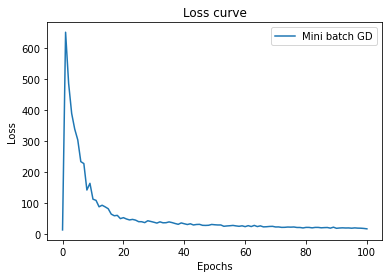

In [298]:
lr_init_mini_batch = 0.001
batch_size_mini_batch = 15

learned_W_mini_batch, loss_list_mini_batch = MiniBatchGradientDescent(x_train, y_train, W.T, batch_size=batch_size_mini_batch, lr_init=lr_init_mini_batch, regularizer=0.8, num_iter=100, schedule=None)

pred = np.dot(x_test, learned_W_mini_batch)
accuracy = np.sum([1 if pred[i]*y_test[i] >= 0 else 0 for i in range(len(pred))])/len(pred)
print("Accuracy =",accuracy*100)

plt.title("Loss curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
x = np.arange(101)
plt.plot(x, loss_list_mini_batch, label="Mini batch GD")
plt.legend()
plt.show()

# **Calling Stochastic GD function**

Accuracy = 57.011635027556636


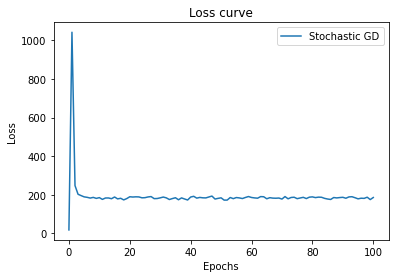

In [299]:
lr_init_SGD = 0.001

learned_W_sgd, loss_list_stoc = StochasticGradientDescent(x_train, y_train, W.T, lr_init=0.001, regularizer=0.9, num_iter=100, schedule=clr)

pred = np.dot(x_test, learned_W_sgd)
accuracy = np.sum([1 if pred[i]*y_test[i] >= 0 else 0 for i in range(len(pred))])/len(pred)
print("Accuracy =",accuracy*100)

plt.title("Loss curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
x = np.arange(101)
plt.plot(x, loss_list_stoc, label="Stochastic GD")
plt.legend()
plt.show()

# **Calling Steepest GD function**

Accuracy = 73.81098183302714


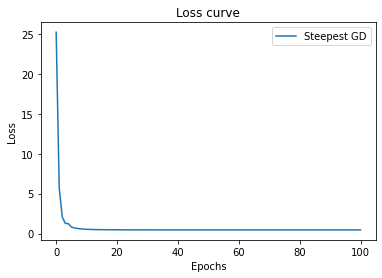

In [300]:
lr_init_Steep_GD = 0.001

learned_W_steep_gd, loss_list_step = GradientDescentLineSearch(x_train, y_train, W.T, lr_init=0.01, regularizer = DEFAULT_REGULARIZER, gamma = 1e-04, num_iter = 100, schedule=None)

pred = np.dot(x_test, learned_W_steep_gd)
accuracy = np.sum([1 if pred[i]*y_test[i] >= 0 else 0 for i in range(len(pred))])/len(pred)
print("Accuracy =",accuracy*100)

plt.title("Loss curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
x = np.arange(101)
plt.plot(x, loss_list_step, label="Steepest GD")
plt.legend()
plt.show()

# **Plot of all 3 loss curves**

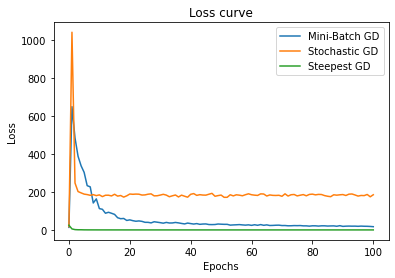

In [301]:
plt.title("Loss curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
x = np.arange(101)
plt.plot(x,loss_list_mini_batch, label="Mini-Batch GD")
plt.plot(x,loss_list_stoc, label="Stochastic GD")
plt.plot(x,loss_list_step, label="Steepest GD")
plt.legend()
plt.show()

# **GRID Representation**

In [302]:
grid = []
for i in np.arange(-3, 3.01, 0.1):
    for j in np.arange(-3, 3.01, 0.1):
        grid.append([i,j])

grid_df = pd.DataFrame(grid, columns=['f1', 'f2'])
## Create new features from f1 and f2
grid_df['f3'] = grid_df['f1']**2 + grid_df['f2']**2
grid_df['f4'] = grid_df['f1']**2
grid_df['f5'] = grid_df['f2']**2
grid_df['f6'] = grid_df['f1'] * grid_df['f2']
grid_df['f7'] = grid_df['f1'] * grid_df['f1']
grid_df['f8'] = grid_df['f2'] * grid_df['f2']
grid_df['f9'] = (grid_df['f1'] * grid_df['f2'] + 1)**2
grid_df['f10'] = np.exp(-0.3*(grid_df['f1'] - grid_df['f2'])**2)

In [303]:
x_grid = grid_df.to_numpy()
y_grid = np.dot(x_grid, learned_W_mini_batch)
y_grid = np.array([1 if y_grid[i] > 0 else -1 for i in range(len(y_grid))])
plt.scatter(x_grid[:,0][y_grid==-1], x_grid[:,1][y_grid==-1], s=3, c='r')
plt.scatter(x_grid[:,0][y_grid==1], x_grid[:,1][y_grid==1], s=3, c='b')
plt.savefig('mini_batch_grid.jpg')
plt.close()

x_grid = grid_df.to_numpy()
y_grid = np.dot(x_grid, learned_W_sgd)
y_grid = np.array([1 if y_grid[i] > 0 else -1 for i in range(len(y_grid))])
plt.scatter(x_grid[:,0][y_grid==-1], x_grid[:,1][y_grid==-1], s=3, c='r')
plt.scatter(x_grid[:,0][y_grid==1], x_grid[:,1][y_grid==1], s=3, c='b')
plt.savefig('sgd_grid.jpg')
plt.close()

x_grid = grid_df.to_numpy()
y_grid = np.dot(x_grid, learned_W_steep_gd)
y_grid = np.array([1 if y_grid[i] > 0 else -1 for i in range(len(y_grid))])
plt.scatter(x_grid[:,0][y_grid==-1], x_grid[:,1][y_grid==-1], s=3, c='r')
plt.scatter(x_grid[:,0][y_grid==1], x_grid[:,1][y_grid==1], s=3, c='b')
plt.savefig('steep_gd_grid.jpg')
plt.close()

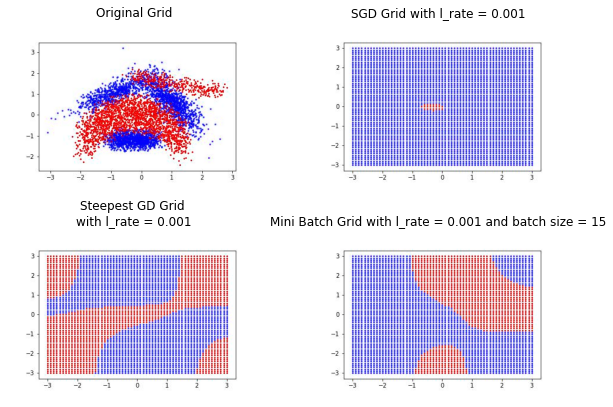

In [309]:
Image1 = cv2.imread('original_grid.jpg')
Image2 = cv2.imread('sgd_grid.jpg')
Image3 = cv2.imread('steep_gd_grid.jpg')
Image4 = cv2.imread('mini_batch_grid.jpg')

# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 2
columns = 2

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("Original Grid")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("SGD Grid with l_rate = {}".format(lr_init_SGD))
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Steepest GD Grid \n l_rate = {}".format(lr_init_Steep_GD))
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(Image4)
plt.axis('off')
plt.title("Mini Batch Grid \n l_rate = {} and batch size = {}".format(lr_init_mini_batch,batch_size_mini_batch))
print()